In [1]:
import numpy as np
import pandas as pd
from aisynphys.database import default_db as db
from aisynphys.cell_class import CellClass, classify_cells, classify_pairs
from aisynphys.connectivity import measure_connectivity, pair_was_probed, GaussianModel, recip_connectivity_profile
from aisynphys.ui.notebook import show_connectivity_profile, show_distance_binned_cp, show_connectivity_raster, set_distance_xticks 
from aisynphys.ui.notebook import cell_class_matrix, ei_hist_plot, plot_metric_pairs, metric_stats
import aisynphys.ui.notebook as nb
import matplotlib.colors, matplotlib.cm
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
%matplotlib inline
plt.rcParams["font.sans-serif"] = "Arial"
print(db.schema_version)

18


# Connection probability

In [2]:
projects = ['human coarse matrix',]
human_pairs = db.pair_query(project_name=projects).all()
print("loaded %d cell pairs" % len(human_pairs))

loaded 10400 cell pairs


### Connectivity-distance profiles

In [3]:
all_type = CellClass("All")
all_connectivity = measure_connectivity({(all_type, all_type): human_pairs}, fit_model=GaussianModel, dist_measure='lateral_distance')

Text(0, 0.5, 'Connection Probability')

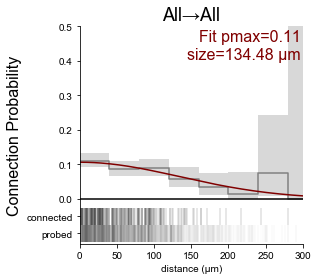

In [4]:
pair_class, results = list(all_connectivity.items())[0]
fit, ax = plt.subplots(figsize=(4,4))
dist = results['probed_distances']
conn = results['connected_distances']
fit = results['connectivity_fit']
show_connectivity_profile(dist, conn, ax, fit, ymax=0.5)
label = ( "Fit pmax=%0.2f\nsize=%0.2f µm" % (fit.pmax, fit.size*1e6))
ax.text(0.99, 0.85, label, transform=ax.transAxes, color=(0.5, 0, 0), horizontalalignment='right', fontsize=16)
ax.set_title("%s→%s" % (pair_class[0], pair_class[1]), fontsize=18)
ax.set_xlim(0, 300e-6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('Connection Probability', fontsize=16)

We'll use this value, 135 um, as the standard correction for all matrices

## Connection probability matrix

In [5]:
import matplotlib
def plot_cp_matrix(cell_classes, distance_adjusted=False):
    # Group all cells by selected classes
    cell_groups = classify_cells(cell_classes.values(), pairs=human_pairs)

    # Group pairs into (pre_class, post_class) groups
    pair_groups = classify_pairs(human_pairs, cell_groups)

    # analyze matrix elements
    kwargs = dict(sigma=135e-6, dist_measure='lateral_distance') if distance_adjusted else {}
    connectivity_results = measure_connectivity(pair_groups, fit_model=GaussianModel, **kwargs)

    # define a colormap and log normalization used to color the heatmap
    norm = matplotlib.colors.LogNorm(vmin=0.01, vmax=1.0, clip=True)
    cmap = matplotlib.cm.get_cmap('plasma')

    # define the display labels to use for each cell subclass:
    class_labels = {key: key for key in cell_classes.keys()}

    # create a figure/axes to draw on
    size = len(cell_classes)
    conn_fig, ax = plt.subplots(figsize=(size,size))

    # finally, draw the colormap using the provided function:
    im, cbar, labels = nb.show_connectivity_matrix(
        ax=ax, 
        results=connectivity_results, 
        pre_cell_classes=cell_classes.values(), 
        post_cell_classes=cell_classes.values(), 
        class_labels=class_labels,
        cmap=cmap, 
        norm=norm,
        ctype='chemical',
        distance_adjusted=distance_adjusted,
        alpha=True,
#         layer_lines=[3.5], 
    )
    plt.ylabel(None)
    plt.xlabel(None)

/home/tom.chartrand/work/aisynphys/aisynphys/connectivity.py:286: RuntimeWarning: Mean of empty slice.
  mean_cp = np.exp(-x_probed**2 / (2 * sigma**2)).mean()
/local1/storage/envs/synphys/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tom.chartrand/work/aisynphys/aisynphys/connectivity.py:292: RuntimeWarning: invalid value encountered in long_scalars
  est_pmax = (n_conn / n_test) / mean_cp
/home/tom.chartrand/work/aisynphys/aisynphys/connectivity.py:286: RuntimeWarning: Mean of empty slice.
  mean_cp = np.exp(-x_probed**2 / (2 * sigma**2)).mean()
/local1/storage/envs/synphys/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tom.chartrand/work/aisynphys/aisynphys/connectivity.py:292: RuntimeWarning: invalid value encountered in long_scalars
  est_pmax = (n_conn / n_test

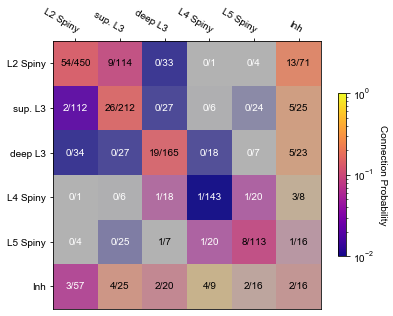

In [6]:
combined_cell_classes = {
    'L2 Spiny': CellClass('L2 Spiny', dendrite_type='spiny', layer='Layer2'),
    'sup. L3': CellClass('sup. L3', db.CorticalCellLocation.fractional_layer_depth < 0.5, 
                         layer = 'Layer3', dendrite_type='spiny'),
    'deep L3': CellClass('deep L3', db.CorticalCellLocation.fractional_layer_depth > 0.5, 
                         layer = 'Layer3', dendrite_type='spiny'),
    'L4 Spiny': CellClass('L4 Spiny', dendrite_type='spiny', cortical_layer='4'),
    'L5 Spiny': CellClass('L5 Spiny', dendrite_type='spiny', cortical_layer='5'),
    'Inh':    CellClass('Inh', cell_class_nonsynaptic='in'),  # aspiny or sparsely spiny
}
plot_cp_matrix(combined_cell_classes, distance_adjusted=True)

In [51]:
# from statsmodels.stats.proportion import proportions_chisquare
from scipy.stats import fisher_exact

def proportions_fisher(hits, totals):
    misses = [t-h for h, t in zip(hits, totals)]
    return fisher_exact([hits, misses])

In [52]:
# L3 L2 vs reverse
proportions_fisher([2,9],[112,114])

(0.21212121212121213, 0.05915711909759136)

In [55]:
# L2 to L3 depths
proportions_fisher([9,0],[114,33])

(inf, 0.20882222327925193)

In [56]:
# L2+supL3 to L3 depths
proportions_fisher([35,0],[326,60])

(inf, 0.0028431080344551865)

In [57]:
# recurrent over cross in L3
proportions_fisher([26+19,0],[212+165,27*2])

(inf, 0.003176903718360044)

In [60]:
# l4 vs deep l3 recurrent
proportions_fisher([1,19],[143,165])

(0.054114158636026685, 8.04414053085053e-05)

In [58]:
# human v mouse L4 recurrent
proportions_fisher([1,34],[143,431])

(0.08222866611433306, 0.000858451952009457)

### Rin filter on Cp matrix

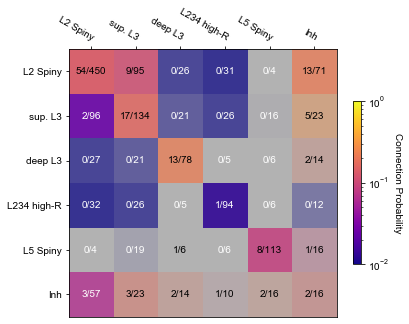

In [66]:
rcut = 300e6
combined_cell_classes = {
    'L2 Spiny': CellClass('L2 Spiny', dendrite_type='spiny', layer='Layer2'),
    'sup. L3': CellClass('sup. L3', db.CorticalCellLocation.fractional_layer_depth < 0.5, 
                          db.Intrinsic.input_resistance < rcut,
                         layer = 'Layer3', dendrite_type='spiny'),
    'deep L3': CellClass('deep L3', db.CorticalCellLocation.fractional_layer_depth > 0.5, 
                          db.Intrinsic.input_resistance < rcut,
                         layer = 'Layer3', dendrite_type='spiny'),
    'L234 high-R': CellClass('L234 high-R', db.Intrinsic.input_resistance > rcut, 
                          cortical_layer=('2','3','4'), dendrite_type='spiny'),
    'L5 Spiny': CellClass('L5 Spiny', dendrite_type='spiny', cortical_layer='5'),
    'Inh':    CellClass('Inh', cell_class_nonsynaptic='in'),  # aspiny or sparsely spiny
}
plot_cp_matrix(combined_cell_classes, distance_adjusted=True)

# Connection property matrices

In [8]:
cell_class_criteria = {
    'L2 Exc': {'cell_class': 'ex', 'cortical_layer': '2'},
    'L3 Exc': {'cell_class': 'ex', 'cortical_layer': '3'},
#     'L4 Exc': {'cell_class': 'ex', 'cortical_layer': '4'},
    'L5 Exc': {'cell_class': 'ex', 'cortical_layer': '5'},
#     'L6 Exc': {'cell_class': 'ex', 'cortical_layer': '6'},
    'Inh':    {'cell_class': 'in'},  
}

cell_classes = {name:CellClass(name=name, **criteria) for name,criteria in cell_class_criteria.items()}
class_labels = {key: key for key in cell_classes.keys()}

# If we check with Inh restricted to FS cells, less data but no noticeable differences
cell_classes_fs = cell_classes
fs = CellClass('FS', db.Intrinsic.width < 0.62e-3)
cell_classes_fs['Inh'] = fs

ei_classes = {'ex': CellClass(cell_class='ex'), 'in': CellClass(cell_class='in')}

pair_query_args = {
#     'project_name': ['mouse V1 pre-production', 'mouse V1 coarse matrix'],
    'species': 'human',
    'synapse': True,
    'filter_exprs': [db.Synapse.latency < 3e-3]
}

In [9]:
l23_cell_classes = {
    'sup. L2': CellClass('sup. L2', db.CorticalCellLocation.fractional_layer_depth < 0.5, 
                         cortical_layer = '2', cell_class='ex'),
    'deep L2': CellClass('deep L2', db.CorticalCellLocation.fractional_layer_depth > 0.5, 
                         cortical_layer = '2', cell_class='ex'),
    'sup. L3': CellClass('sup. L3', db.CorticalCellLocation.fractional_layer_depth < 0.5, 
                         cortical_layer = '3', cell_class='ex'),
    'deep L3': CellClass('deep L3', db.CorticalCellLocation.fractional_layer_depth > 0.5, 
                         cortical_layer = '3', cell_class='ex'),
    'Inh':    CellClass('Inh', cell_class='in'),  
#     'Inh':    fs, 
}
l23_class_labels = {key: key for key in l23_cell_classes.keys()}
# l23_cell_classes['Inh'] = fs


In [10]:
l23_inh_classes = {
    'L2 Spiny': CellClass('L2 Spiny', dendrite_type='spiny', layer='Layer2'),
    'sup. L3': CellClass('sup. L3', db.CorticalCellLocation.fractional_layer_depth < 0.5, 
                         layer = 'Layer3', dendrite_type='spiny'),
    'deep L3': CellClass('deep L3', db.CorticalCellLocation.fractional_layer_depth > 0.5, 
                         layer = 'Layer3', dendrite_type='spiny'),
    'Inh':    CellClass('Inh', cell_class_nonsynaptic='in'),  # aspiny or sparsely spiny
}

In [11]:
def ei_hist_plot(metric, bin_edges, db, pair_query_args):
    fig, ax = plt.subplots(figsize=(4,3))
    ei_classes = {'ex': CellClass(cell_class='ex'), 'in': CellClass(cell_class='in')}
    
    pairs_has_metric, metric_name, units, scale, _, _, _, _, _ = nb.get_metric_data(metric, db, ei_classes, ei_classes, pair_query_args=pair_query_args)
    ex_pairs = pairs_has_metric[pairs_has_metric['pre_class']=='ex']
    if 'amp' in metric:
        ax.hist(ex_pairs[metric]*scale, bins=bin_edges, color=(0.8, 0.8, 0.8), label='All Excitatory Synapses')
    else:
        ax.hist(pairs_has_metric[metric]*scale, bins=bin_edges, color=(0.8, 0.8, 0.8), label='All Synapses')

    ee_pairs = ex_pairs[ex_pairs['post_class']=='ex']
    ei_pairs = ex_pairs[ex_pairs['post_class']=='in']
    ax.hist(ee_pairs[metric]*scale, bins=bin_edges, color='red', alpha=0.6, label='E->E Synapses')
    ax.hist(ei_pairs[metric]*scale, bins=bin_edges, color='pink', alpha=0.8, label='E->I Synapses')
    ax.legend(frameon=False)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('%s (%s)' % (metric_name, units))
    ax.set_ylabel('Number of Synapses', fontsize=12)

    #KS test
    excitatory = nb.stats.ks_2samp(ee_pairs[metric], ei_pairs[metric])
    print('Two-sample KS test for %s' % metric)
    print('Excitatory: p = %0.3e' % excitatory[1])

### Latency

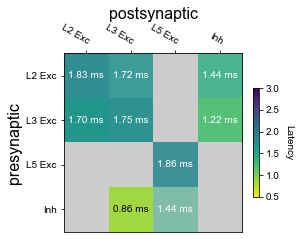

In [12]:
latency_fig, ax = plt.subplots(figsize=(4,4))
latency_df = cell_class_matrix(cell_classes, cell_classes, 'latency', class_labels, ax, db, pair_query_args=pair_query_args)

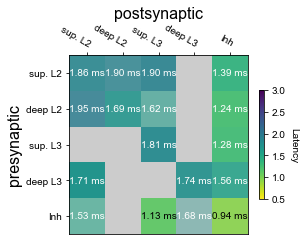

In [13]:
latency_fig, ax = plt.subplots(figsize=(4,4))
latency_df = nb.cell_class_matrix(l23_cell_classes, l23_cell_classes, 'latency', None, ax, db, pair_query_args=pair_query_args)

Two-sample KS test for latency
Excitatory: p = 1.244e-04


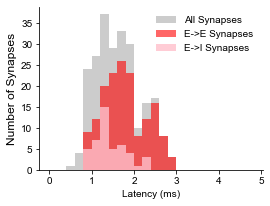

In [14]:
bin_edges = np.arange(0, 5, 0.2)
ei_hist_plot('latency', bin_edges, db, pair_query_args)

### Rise Tau

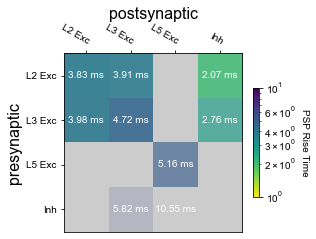

In [15]:
latency_fig, ax = plt.subplots(figsize=(4,4))
latency_df = cell_class_matrix(cell_classes, cell_classes, 'psp_rise_time', class_labels, ax, db, pair_query_args=pair_query_args)

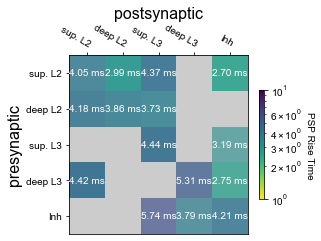

In [16]:
latency_fig, ax = plt.subplots(figsize=(4,4))
latency_df = cell_class_matrix(l23_cell_classes, l23_cell_classes, 'psp_rise_time', l23_class_labels, ax, db, pair_query_args=pair_query_args)

Two-sample KS test for psp_rise_time
Excitatory: p = 6.242e-09


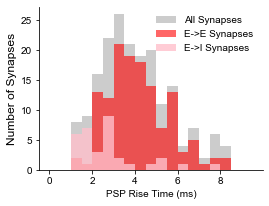

In [17]:
bin_edges = np.arange(0, 10, 0.5)
ei_hist_plot('psp_rise_time', bin_edges, db, pair_query_args)

### Resting state PSP amplitude

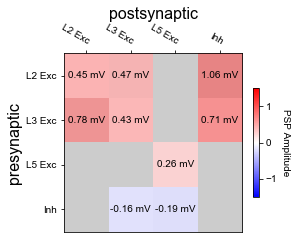

In [18]:
latency_fig, ax = plt.subplots(figsize=(4,4))
latency_df = cell_class_matrix(cell_classes, cell_classes, 'psp_amplitude', class_labels, ax, db, pair_query_args=pair_query_args)

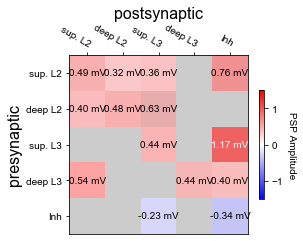

In [19]:
latency_fig, ax = plt.subplots(figsize=(4,4))
latency_df = cell_class_matrix(l23_cell_classes, l23_cell_classes, 'psp_amplitude', l23_class_labels, ax, db, pair_query_args=pair_query_args)

Two-sample KS test for psp_amplitude
Excitatory: p = 3.070e-04


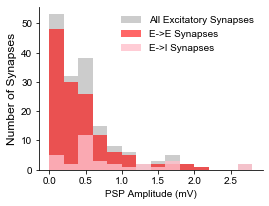

In [20]:
bin_edges = np.arange(0, 3, 0.2)
ei_hist_plot( 'psp_amplitude', bin_edges, db, pair_query_args=pair_query_args)

### STP Induction

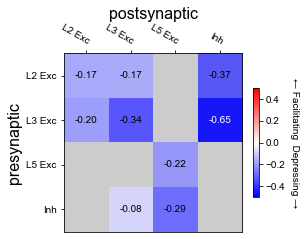

In [21]:
latency_fig, ax = plt.subplots(figsize=(4,4))
latency_df = cell_class_matrix(cell_classes, cell_classes, 'stp_induction_50hz', class_labels, ax, db, pair_query_args=pair_query_args)

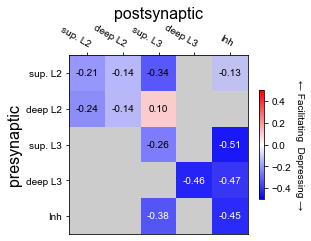

In [22]:
latency_fig, ax = plt.subplots(figsize=(4,4))
latency_df = cell_class_matrix(l23_cell_classes, l23_cell_classes, 'stp_induction_50hz', None, ax, db, pair_query_args=pair_query_args)

## Additional PSP/C response matrices

### 90th percentile PSP amplitude 

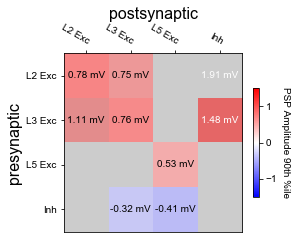

In [23]:
latency_fig, ax = plt.subplots(figsize=(4,4))
latency_df = cell_class_matrix(cell_classes, cell_classes, 'pulse_amp_90th_percentile', class_labels, ax, db, pair_query_args=pair_query_args)

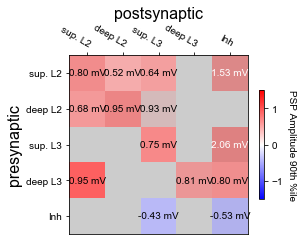

In [24]:
latency_fig, ax = plt.subplots(figsize=(4,4))
latency_df = cell_class_matrix(l23_cell_classes, l23_cell_classes, 'pulse_amp_90th_percentile', l23_class_labels, ax, db, pair_query_args=pair_query_args)

Two-sample KS test for pulse_amp_90th_percentile
Excitatory: p = 9.107e-05


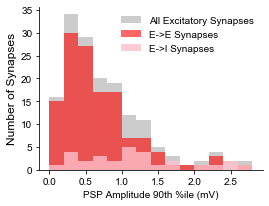

In [25]:
bin_edges = np.arange(0, 3, 0.2)
ei_hist_plot( 'pulse_amp_90th_percentile', bin_edges, db, pair_query_args=pair_query_args)

### Resting state amplitude of PSC 

Not sure why the numbers are so much lower here...

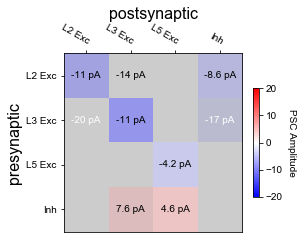

In [26]:
latency_fig, ax = plt.subplots(figsize=(4,4))
latency_df = cell_class_matrix(cell_classes, cell_classes, 'psc_amplitude', class_labels, ax, db, pair_query_args=pair_query_args)

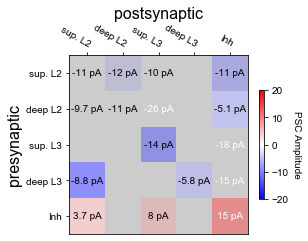

In [27]:
latency_fig, ax = plt.subplots(figsize=(4,4))
latency_df = cell_class_matrix(l23_cell_classes, l23_cell_classes, 'psc_amplitude', l23_class_labels, ax, db, pair_query_args=pair_query_args)

Two-sample KS test for psc_amplitude
Excitatory: p = 5.454e-03


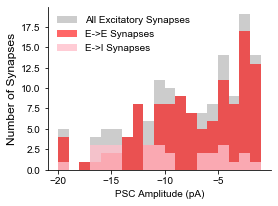

In [28]:
bin_edges = np.arange(-20, 0, 1)
ei_hist_plot( 'psc_amplitude', bin_edges, db, pair_query_args=pair_query_args)

### STP Initial

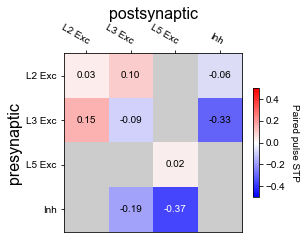

In [29]:
latency_fig, ax = plt.subplots(figsize=(4,4))
latency_df = cell_class_matrix(cell_classes, cell_classes, 'stp_initial_50hz', class_labels, ax, db, pair_query_args=pair_query_args)

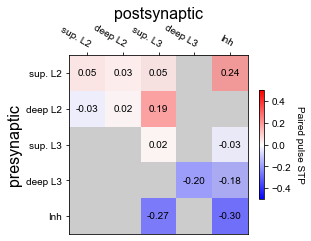

In [30]:
latency_fig, ax = plt.subplots(figsize=(4,4))
latency_df = cell_class_matrix(l23_cell_classes, l23_cell_classes, 'stp_initial_50hz', l23_class_labels, ax, db, pair_query_args=pair_query_args)

### STP Recovery

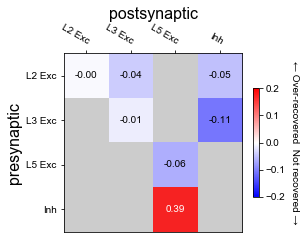

In [31]:
latency_fig, ax = plt.subplots(figsize=(4,4))
latency_df = cell_class_matrix(cell_classes, cell_classes, 'stp_recovery_250ms', class_labels, ax, db, pair_query_args=pair_query_args)

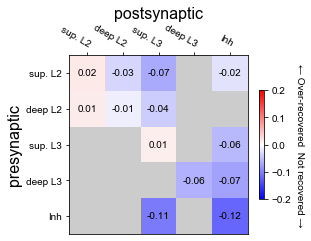

In [32]:
latency_fig, ax = plt.subplots(figsize=(4,4))
latency_df = cell_class_matrix(l23_cell_classes, l23_cell_classes, 'stp_recovery_250ms', l23_class_labels, ax, db, pair_query_args=pair_query_args)

## Additional connection matrix views

In [33]:
cell_class_criteria = {
    'L2 Spiny': {'dendrite_type': 'spiny', 'cortical_layer': '2'},
    'L3 Spiny': {'dendrite_type': 'spiny', 'cortical_layer': '3'},
    'L4 Spiny': {'dendrite_type': 'spiny', 'cortical_layer': '4'},
    'L5 Spiny': {'dendrite_type': 'spiny', 'cortical_layer': '5'},
#     'L6 Spiny': {'dendrite_type': 'spiny', 'cortical_layer': '6'},
    'Inh':    {'cell_class_nonsynaptic': 'in'},  # aspiny or sparsely spiny
}

cell_classes = {name:CellClass(name=name, **criteria) for name,criteria in cell_class_criteria.items()}
# cell_classes['FS'] = CellClass('FS', db.Intrinsic.width < 0.62e-3)

/home/tom.chartrand/work/aisynphys/aisynphys/connectivity.py:286: RuntimeWarning: Mean of empty slice.
  mean_cp = np.exp(-x_probed**2 / (2 * sigma**2)).mean()
/local1/storage/envs/synphys/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tom.chartrand/work/aisynphys/aisynphys/connectivity.py:292: RuntimeWarning: invalid value encountered in long_scalars
  est_pmax = (n_conn / n_test) / mean_cp
/home/tom.chartrand/work/aisynphys/aisynphys/connectivity.py:286: RuntimeWarning: Mean of empty slice.
  mean_cp = np.exp(-x_probed**2 / (2 * sigma**2)).mean()
/local1/storage/envs/synphys/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tom.chartrand/work/aisynphys/aisynphys/connectivity.py:292: RuntimeWarning: invalid value encountered in long_scalars
  est_pmax = (n_conn / n_test

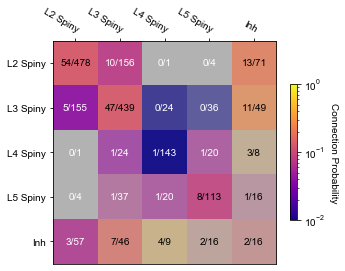

In [34]:
plot_cp_matrix(cell_classes, distance_adjusted=True)

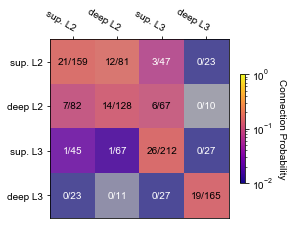

In [35]:
l23_cell_classes = {
    'sup. L2': CellClass('sup. L2', db.CorticalCellLocation.fractional_layer_depth < 0.5, 
                         layer = 'Layer2', dendrite_type='spiny'),
    'deep L2': CellClass('deep L2', db.CorticalCellLocation.fractional_layer_depth > 0.5, 
                         layer = 'Layer2', dendrite_type='spiny'),
    'sup. L3': CellClass('sup. L3', db.CorticalCellLocation.fractional_layer_depth < 0.5, 
                         layer = 'Layer3', dendrite_type='spiny'),
    'deep L3': CellClass('deep L3', db.CorticalCellLocation.fractional_layer_depth > 0.5, 
                         layer = 'Layer3', dendrite_type='spiny'),
}

plot_cp_matrix(l23_cell_classes, distance_adjusted=True)

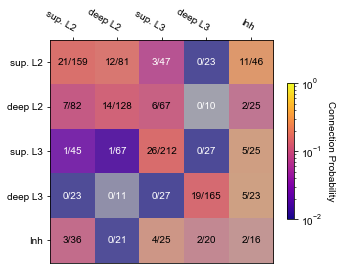

In [36]:
plot_cp_matrix(dict(**l23_cell_classes, Inh=CellClass('Inh', cell_class_nonsynaptic='in')), distance_adjusted=True)

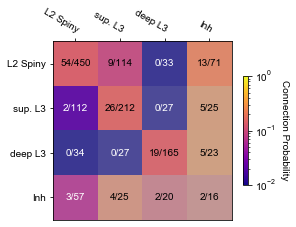

In [37]:
l23_inh_classes = {
    'L2 Spiny': CellClass('L2 Spiny', dendrite_type='spiny', layer='Layer2'),
    'sup. L3': CellClass('sup. L3', db.CorticalCellLocation.fractional_layer_depth < 0.5, 
                         layer = 'Layer3', dendrite_type='spiny'),
    'deep L3': CellClass('deep L3', db.CorticalCellLocation.fractional_layer_depth > 0.5, 
                         layer = 'Layer3', dendrite_type='spiny'),
    'Inh':    CellClass('Inh', cell_class_nonsynaptic='in'),  # aspiny or sparsely spiny
}
plot_cp_matrix(l23_inh_classes, distance_adjusted=True)

## Additional connectivity profiles - distance vs. lateral, split by class

In [38]:
# Need to adjust axis labels to lateral distance if using
def plot_conn_profile(dist_measure='lateral_distance'):
    ei_classes = {'excit': CellClass(cell_class_nonsynaptic='ex', name='excit'), 
                  'inhib': CellClass(cell_class_nonsynaptic='in', name='inhib')}
    ei_cell_groups = classify_cells(ei_classes.values(), pairs=human_pairs)
    ei_pair_groups = classify_pairs(human_pairs, ei_cell_groups)
    x_bins = np.arange(0, 540e-6, 40e-6)
    x_vals = np.linspace(x_bins[0], x_bins[-1], 200)

    ei_connectivity = measure_connectivity(ei_pair_groups, fit_model=GaussianModel, dist_measure=dist_measure)

    dist_fig = plt.figure(figsize=(6*len(ei_connectivity), 10))
    grid = gridspec.GridSpec(2, len(ei_connectivity), height_ratios=[1,0.5])
    ax = [[dist_fig.add_subplot(grid[x, y]) for y in range(len(ei_connectivity))] for x in [0, 1]]

    for i, (pair_class, results) in enumerate(ei_connectivity.items()):
        dist = results['probed_distances']
        conn = results['connected_distances']
        fit = results['connectivity_fit']
        show_connectivity_profile(dist, conn, ax[0][i], fit, ymax=0.5)
        label = ( "Fit pmax=%0.2f\nsize=%0.2f µm" % (fit.pmax, fit.size*1e6))
        ax[0][i].text(0.99, 0.85, label, transform=ax[0][i].transAxes, color=(0.5, 0, 0), horizontalalignment='right', fontsize=16)
        ax[0][i].set_title("%s→%s" % (pair_class[0], pair_class[1]), fontsize=18)
        ax[0][i].set_xlim(0, 300e-6)
        ax[0][i].spines['right'].set_visible(False)
        ax[0][i].spines['top'].set_visible(False)

        ax[0][0].set_ylabel('Connection Probability', fontsize=16)

        ## calculate and plot reciprocal connectivity
        ymax = 9
        if pair_class != pair_class[::-1]:
            results_2 = ei_connectivity[pair_class[::-1]]
        else:
            results_2 = results
        norm_cp_r, recip_conn, recip_dist = recip_connectivity_profile(results['probed_pairs'], results_2['probed_pairs'], x_bins)
        show_distance_binned_cp(x_bins, norm_cp_r, ax[1][i])
        tickheight = ymax / 5
        show_connectivity_raster(recip_dist, recip_conn, tickheight, ax[1][i])
        set_distance_xticks(x_vals, ax[1][i], interval=100e-6)
        set_distance_xticks(x_vals, ax[0][i], interval=100e-6)

        y_vals = np.arange(1, ymax + 0.5, 2)
        ax[1][i].set_yticks([-tickheight*2, -tickheight] + list(y_vals))
        ax[1][i].set_yticklabels(['probed', 'reciprocal'] + ['%.1f'%x for x in y_vals])
        ax[1][i].set_ylim(-tickheight*2.6, ymax)
        ax[1][i].axhline(0, color=(0,0,0))
        ax[1][i].axhline(1, color=(0.5, 0, 0), linestyle='--')
        ax[1][i].spines['right'].set_visible(False)
        ax[1][i].spines['top'].set_visible(False)

        ax[1][i].set_xlim(0, 300e-6)

        ax[1][0].set_ylabel('Norm Reciprocal Rate', fontsize=16)

/home/tom.chartrand/work/aisynphys/aisynphys/connectivity.py:596: RuntimeWarning: invalid value encountered in true_divide
  norm_cp_r = cp_r / (cp_1 * cp_2)
/home/tom.chartrand/work/aisynphys/aisynphys/ui/notebook.py:581: RuntimeWarning: divide by zero encountered in long_scalars
  alpha2 = np.clip(30 / conn.sum(), 1/255, 1)


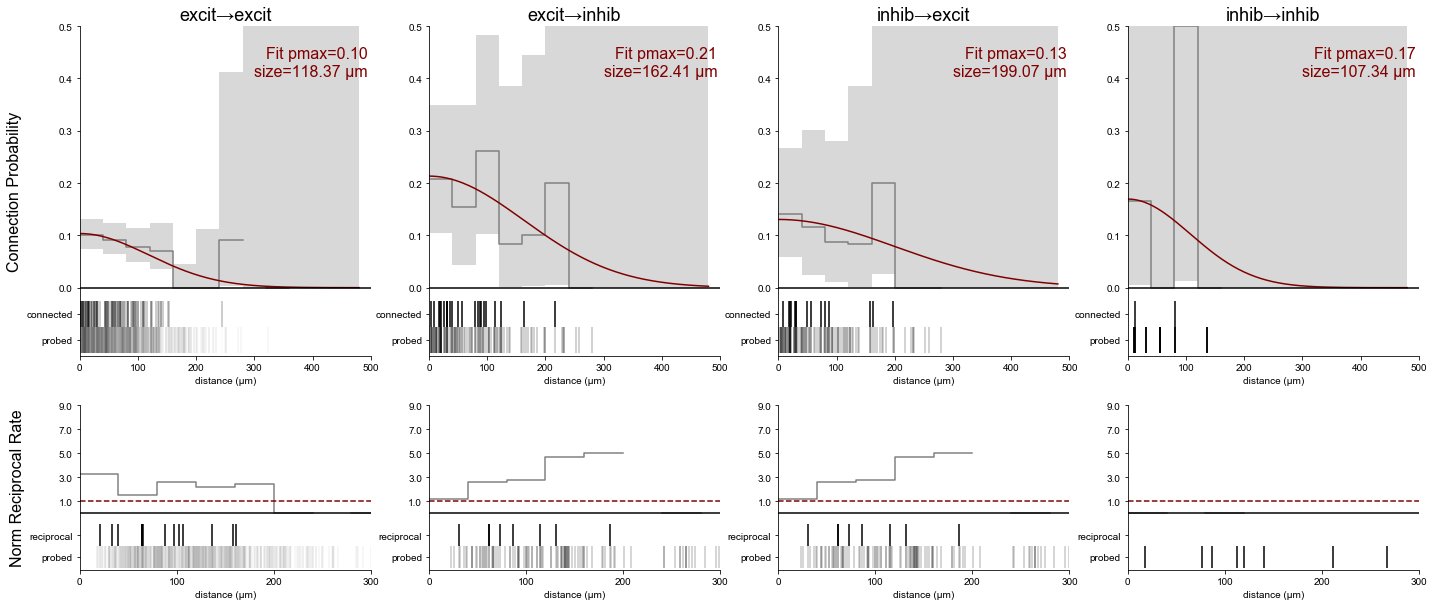

In [39]:
plot_conn_profile(dist_measure='lateral_distance')

/home/tom.chartrand/work/aisynphys/aisynphys/connectivity.py:596: RuntimeWarning: invalid value encountered in true_divide
  norm_cp_r = cp_r / (cp_1 * cp_2)
/home/tom.chartrand/work/aisynphys/aisynphys/ui/notebook.py:581: RuntimeWarning: divide by zero encountered in long_scalars
  alpha2 = np.clip(30 / conn.sum(), 1/255, 1)


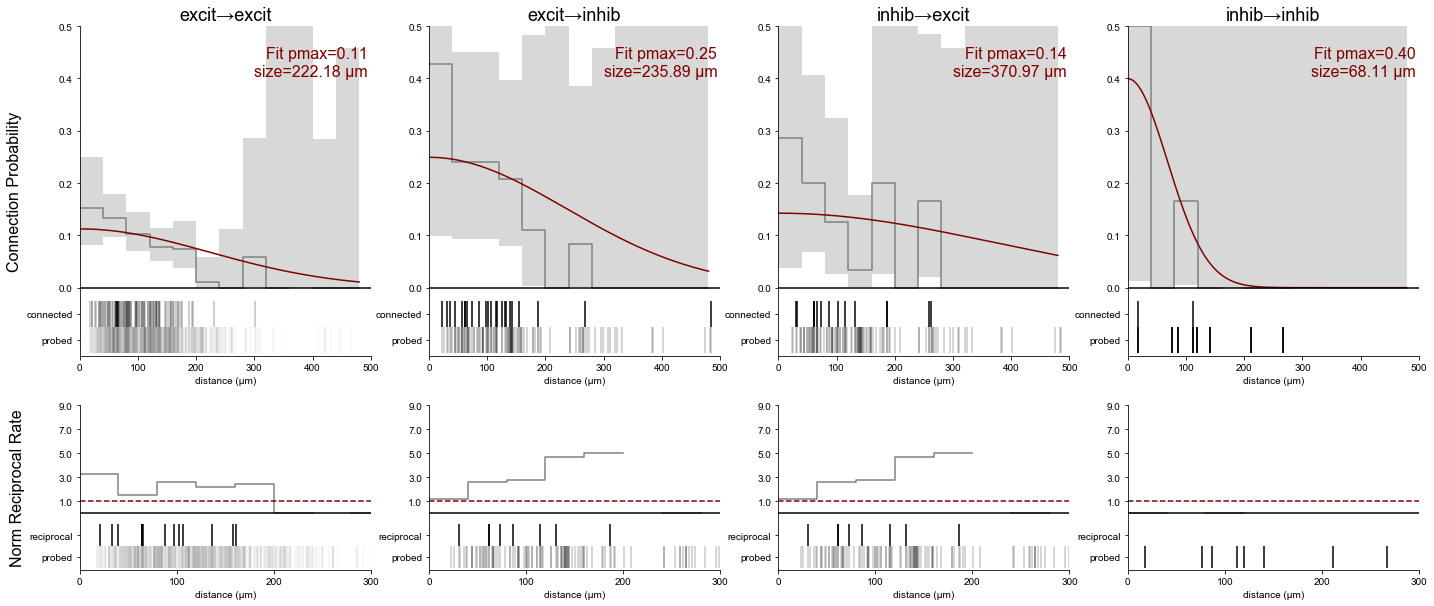

In [40]:
plot_conn_profile(dist_measure='distance')